# Dependecies

In [ ]:
# !pip install q tensorflow==2.6.0 #install tensorflow

In [ ]:
!pip install keras-metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import keras
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import scipy.stats
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
# from keras.utils import np_utils
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras import optimizers
from imblearn.over_sampling import SMOTE

from keras import backend
from keras.layers import Dense
# from keras.layers import LSTM
from keras.regularizers import l2, l1
from keras.layers import Dropout,Bidirectional,TimeDistributed

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import l2, l1
from keras.layers import Dropout, TimeDistributed, Bidirectional
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras import optimizers
import keras
from keras import backend as K
import tensorflow as tf
import keras_metrics

from tensorflow import keras; 
from tensorflow.keras import layers;
from tensorflow.keras import metrics

from matplotlib import pyplot
import pandas as pd
from sklearn import preprocessing
from numpy import array
import numpy as np
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from keras.utils import np_utils
from keras.layers.merge import concatenate
#
import os

# NHY Classification

In [ ]:
def nhyclassificationtask(AllTimeSeriesData_Training, AllTimeSeriesData_Testing):
  nb_epoch = 75 # 50 
  dataset_total_cases = df.shape[0]
  num_classes = 4 # for binary classes (0 and 1)


  dropoutValue = 0.1 # 0.2
  dropValueRegression = 0.02 # 0.4
  dropValueClassification = 0.015 # 0.25
  regressionActivation = 'sigmoid'
  cvscores = []
  model = None
  results=[]

  X, y = split_sequencessingle(AllTimeSeriesData_Training.values, steps)

  label_encoder = LabelEncoder()

  print("Here you go.... The model training has strated ... Relax and do other work.. ;-)\n")

  # fix random seed for reproducibility
  seed = 2013731
  np.random.seed(seed)
  kfold = StratifiedKFold(n_splits=split, shuffle=True, random_state=seed) 

  ## History list 
  history_list_for_folds = []
  for train_indeices, validate_indeices in kfold.split(X, y):
    # Training 
    X_train = X[train_indeices]
    y_nhy_train = encode_Y(y[train_indeices])
    # Y_reg_train = Y_reg_train.astype(float) 
    # print(y_nhy_train)


    # Validation
    X_validate = X[validate_indeices]
    y_nhy_val = encode_Y(y[validate_indeices])
    # Y_reg_validate = Y_reg_validate.astype(float) 
    # print(y_nhy_val)

    # Featuer Extraction
    X_input = Input(shape=(X_train.shape[1],X_train.shape[2]),name='X_input')
    X_layer1 = Bidirectional(LSTM(256, kernel_regularizer=l2(0.01),return_sequences=True, activation="tanh",name='LSTM_layer1'))(X_input)
    X_layer1 = Dropout(dropoutValue)(X_layer1)
    X_layer2 = Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), activation="tanh", name='LSTM_layer2'))(X_layer1)
    X_layer2 = Dropout(dropoutValue)(X_layer2)
    
    # Classification Problem NHY
    l2Reg = 0.01 # 0.005 original
    nn0 = Dense(64,kernel_regularizer=l2(l2Reg), activation='relu', name='class_layer_1_nhy')(X_layer2)
    nn0 = Dropout(dropoutValue)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_2_nhy')(nn0))
    nn0 = Dropout(dropValueClassification)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_3_nhy')(nn0))

    result_nhy = keras.layers.Dense(num_classes,kernel_regularizer=l2(l2Reg), activation='sigmoid',name='classAccuracy_nhy')(nn0)
    result__nhy_precision = keras.layers.Lambda(lambda x:x, name = "classPrecision_nhy")(result_nhy)
    result__nhy_recall = keras.layers.Lambda(lambda x:x, name = "classRecall_nhy")(result_nhy)   
    result__nhy_f1 = keras.layers.Lambda(lambda x:x, name = "classFscore_nhy")(result_nhy)


    model = Model(inputs=X_input, outputs=[result_nhy, result__nhy_precision, result__nhy_recall, result__nhy_f1])

    plot_model(model, to_file=os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'nhy_model_' + str(steps) + '.png'), show_shapes=True, show_layer_names=True)

    loss_list = {'classAccuracy_nhy':'categorical_crossentropy',
                 'classPrecision_nhy':'categorical_crossentropy',
                 'classRecall_nhy': 'categorical_crossentropy',
                 'classFscore_nhy': 'categorical_crossentropy'}

    test_metrics = {'classAccuracy_nhy': 'accuracy',
                    'classPrecision_nhy':keras_metrics.precision(),
                    'classRecall_nhy': keras_metrics.recall(),
                    'classFscore_nhy': f1score}

    optimizer2 = tf.optimizers.Adam(lr=0.01) # original 0.0001 
    model.compile(optimizer=optimizer2, loss=loss_list,metrics=test_metrics)
    # [print(i.shape, i.dtype) for i in model.inputs]
    # [print(o.shape, o.dtype) for o in model.outputs]
    # print(Y_reg_validate)
    # print(type(Y_reg_validate))
    # print(type(Y_reg_train))
    # print(len(Y_reg_validate))
    # print(len(Y_reg_train))
    history = model.fit({'X_input':X_train}, {'classAccuracy_nhy': y_nhy_train, 
                                              'classPrecision_nhy': y_nhy_train, 
                                              'classRecall_nhy': y_nhy_train, 
                                              'classFscore_nhy': y_nhy_train}, 
                                 epochs=nb_epoch, batch_size=24, shuffle=True, verbose=1, 
                                 validation_data=({'X_input':X_validate}, {'classAccuracy_nhy': y_nhy_val,
                                                                           'classPrecision_nhy': y_nhy_val, 
                                                                           'classRecall_nhy': y_nhy_val, 
                                                                           'classFscore_nhy': y_nhy_val}))
    
    # prepare testing data 

    X_test, y_test = split_sequencessingle(AllTimeSeriesData_Testing.values, steps)
    y_nhy_test = encode_Y(y_test)

    # list all data in history
    _loss,_loss1,_loss11,_loss12,_loss13,_acc,_precision,_recall,_fscore = model.evaluate({'X_input':X_test}, 
                                                                                          {'classAccuracy_nhy': y_nhy_test,
                                                                                           'classPrecision_nhy':y_nhy_test,
                                                                                           'classRecall_nhy': y_nhy_test,
                                                                                           'classFscore_nhy': y_nhy_test},
                                                                                          verbose=0)   
    print("Deep Learning accuracy ",_acc,' precision',_precision,' recall',_recall,' fscore',_fscore)
    results.append([_acc,_precision,_recall,_fscore])

  columns=['accuracy','_precision','_recall','_fscore']
  resultsFrame = pd.DataFrame(results,columns=columns)
  resultsFrame.to_csv(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'nhy_test_' + str(steps) + '.csv'))

    

  # # Plot the loss
  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.title('Model loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('Epoch')
  pyplot.legend(['Train', 'Validate'], loc='upper left')
  pyplot.savefig(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'nhy_val_loss_' + str(steps) + '.png'))

  history_list_for_folds.append(history)
  return history_list_for_folds


# Depression classification

In [ ]:
def depclassificationtask(AllTimeSeriesData_Training,AllTimeSeriesData_Testing):
  nb_epoch = 75 # 50 
  dataset_total_cases = df.shape[0]
  num_classes = 1 # for binary classes (0 and 1)


  dropoutValue = 0.001 # 0.2
  dropValueRegression = 0.02 # 0.4
  dropValueClassification = 0.015 # 0.25
  regressionActivation = 'sigmoid'
  cvscores = []
  model = None
  results=[]

  X, y = split_sequencessingle(AllTimeSeriesData_Training.values, steps)

  label_encoder = LabelEncoder()

  print("Here you go.... The model training has strated ... Relax and do other work.. ;-)\n")

  # fix random seed for reproducibility
  seed = 2013731
  np.random.seed(seed)
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed) # it was 10 
  
  ## History list 
  history_list_for_folds = []
  for train_indeices, validate_indeices in kfold.split(X, y):
    # Training 
    X_train = X[train_indeices]
    y_dep_train = y[train_indeices]
    # Y_reg_train = Y_reg_train.astype(float) 
    # print(Y_cls_train)


    # Validation
    X_validate = X[validate_indeices]
    y_dep_val = y[validate_indeices]
    # Y_reg_validate = Y_reg_validate.astype(float) 

    # Featuer Extraction
    X_input = Input(shape=(X_train.shape[1],X_train.shape[2]),name='X_input')
    X_layer1 = Bidirectional(LSTM(256, kernel_regularizer=l2(0.01),return_sequences=True, activation="tanh",name='LSTM_layer1'))(X_input)
    X_layer1 = Dropout(dropoutValue)(X_layer1)
    X_layer2 = Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), activation="tanh", name='LSTM_layer2'))(X_layer1)
    X_layer2 = Dropout(dropoutValue)(X_layer2)


    # Classification Problem Depression
    l2Reg = 0.05 # 0.005 original
    nn1 = Dense(64,kernel_regularizer=l2(l2Reg), activation='relu', name='class_layer_1_dep')(X_layer2)
    nn1 = Dropout(dropoutValue)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_2_dep')(nn1))
    nn1 = Dropout(dropValueClassification)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_3_dep')(nn1))
    result_dep = keras.layers.Dense(num_classes,kernel_regularizer=l2(l2Reg), activation='sigmoid',name='classAccuracy_dep')(nn1)
    result__dep_precision = keras.layers.Lambda(lambda x:x, name = "classPrecision_dep")(result_dep)
    result__dep_recall = keras.layers.Lambda(lambda x:x, name = "classRecall_dep")(result_dep)   
    result__dep_f1 = keras.layers.Lambda(lambda x:x, name = "classFscore_dep")(result_dep)

    # # Regression Problem
    # nn1 = Dropout(dropValueRegression)(Dense(128, activation='relu',name='regression_layer_1')(X_layer1))
    # nn1 = Dropout(dropValueRegression)(Dense(64, kernel_regularizer=l2(0.001),activation='relu',name='regression_layer_2')(nn1))
    # nn1 = Dropout(dropValueRegression)(Dense(32, kernel_regularizer=l2(0.001), activation='relu',name='regression_layer_3')(nn1))

    # result_mse = keras.layers.Dense(1,activation=regressionActivation, name='regression_mse')(nn1)
    # result_rmse = keras.layers.Dense(1,activation=regressionActivation, name='regression_rmse')(nn1)

    model = Model(inputs=X_input, outputs=[result_dep, result__dep_precision, result__dep_recall, result__dep_f1])

    plot_model(model, to_file=os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'dep_model_' + str(steps) + '.png'), show_shapes=True, show_layer_names=True)

    loss_list = {'classAccuracy_dep':'binary_crossentropy',
                 'classPrecision_dep':'binary_crossentropy',
                 'classRecall_dep': 'binary_crossentropy',
                 'classFscore_dep': 'binary_crossentropy'}

    test_metrics = {'classAccuracy_dep': 'accuracy',
                    'classPrecision_dep':keras_metrics.precision(),
                    'classRecall_dep': keras_metrics.recall(),
                    'classFscore_dep': f1score}

    optimizer2 = tf.optimizers.Adam(lr=0.001) # original 0.0001 
    model.compile(optimizer=optimizer2, loss=loss_list,metrics=test_metrics)
    # [print(i.shape, i.dtype) for i in model.inputs]
    # [print(o.shape, o.dtype) for o in model.outputs]
    # print(Y_reg_validate)
    # print(type(Y_reg_validate))
    # print(type(Y_reg_train))
    # print(len(Y_reg_validate))
    # print(len(Y_reg_train))
    history = model.fit({'X_input':X_train}, {'classAccuracy_dep': y_dep_train, 
                                              'classPrecision_dep': y_dep_train, 
                                              'classRecall_dep': y_dep_train, 
                                              'classFscore_dep': y_dep_train}, 
                                 epochs=nb_epoch, batch_size=24, shuffle=True, verbose=1, 
                                 validation_data=({'X_input':X_validate}, {'classAccuracy_dep': y_dep_val,
                                                                           'classPrecision_dep': y_dep_val, 
                                                                           'classRecall_dep': y_dep_val, 
                                                                           'classFscore_dep': y_dep_val}))
    # prepare testing data 

    X_test, y_test = split_sequencessingle(AllTimeSeriesData_Testing.values, steps)
    Y_dep_test = y_test

    # list all data in history
    _loss,_loss1,_loss11,_loss12,_loss13,_acc,_precision,_recall,_fscore = model.evaluate({'X_input':X_test}, 
                                                                                          {'classAccuracy_dep': Y_dep_test,
                                                                                           'classPrecision_dep':Y_dep_test,
                                                                                           'classRecall_dep': Y_dep_test,
                                                                                           'classFscore_dep': Y_dep_test},
                                                                                          verbose=0)   
    print("Deep Learning accuracy ",_acc,' precision',_precision,' recall',_recall,' fscore',_fscore)
    results.append([_acc,_precision,_recall,_fscore])

  columns=['accuracy','_precision','_recall','_fscore']
  resultsFrame = pd.DataFrame(results,columns=columns)
  resultsFrame.to_csv(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'dep_test_' + str(steps) + '.csv'))

  # # Plot the loss
  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.title('Model loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('Epoch')
  pyplot.legend(['Train', 'Validate'], loc='upper left')
  pyplot.savefig(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'dep_val_loss_' + str(steps) + '.png'))
  print('---------Sucessfully Done-------------Congratulation-----------------------')

  history_list_for_folds.append(history)
  return history_list_for_folds



# Depression Scale Classification

In [ ]:
def depscaleclassificationtask(AllTimeSeriesData_Training, AllTimeSeriesData_Testing):
  nb_epoch = 75 # 50 
  dataset_total_cases = df.shape[0]
  num_classes = 4 # for binary classes (0 and 1)


  dropoutValue = 0.001 # 0.2
  dropValueRegression = 0.02 # 0.4
  dropValueClassification = 0.015 # 0.25
  regressionActivation = 'sigmoid'
  cvscores = []
  model = None
  results=[]

  X, y = split_sequencessingle(AllTimeSeriesData_Training.values, steps)

  label_encoder = LabelEncoder()

  print("Here you go.... The model training has strated ... Relax and do other work.. ;-)\n")

  # fix random seed for reproducibility
  seed = 2013731
  np.random.seed(seed)
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed) # it was 10 
  
  ## History list 
  history_list_for_folds = []
  for train_indeices, validate_indeices in kfold.split(X, y):
    # Training 
    X_train = X[train_indeices]
    y_dep_scale_train = encode_Y(y[train_indeices])
    # Y_reg_train = Y_reg_train.astype(float) 
    # print(Y_cls_train)
     

    # Validation
    X_validate = X[validate_indeices]
    y_dep_scale_val = encode_Y(y[validate_indeices])
    # Y_reg_validate = Y_reg_validate.astype(float) 

      # Featuer Extraction
    X_input = Input(shape=(X_train.shape[1],X_train.shape[2]),name='X_input')
    X_layer1 = Bidirectional(LSTM(256, kernel_regularizer=l2(0.01),return_sequences=True, activation="tanh",name='LSTM_layer1'))(X_input)
    X_layer1 = Dropout(dropoutValue)(X_layer1)
    X_layer2 = Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), activation="tanh", name='LSTM_layer2'))(X_layer1)
    X_layer2 = Dropout(dropoutValue)(X_layer2)

    # Classification Problem NHY
    l2Reg = 0.05 # 0.005 original

    # Classification Problem Depression Scale
    nn2 = Dense(64,kernel_regularizer=l2(l2Reg), activation='relu', name='class_layer_1_dep_scale')(X_layer2)
    nn2 = Dropout(dropoutValue)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_2_dep_scale')(nn2))
    nn2 = Dropout(dropValueClassification)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_3_dep_scale')(nn2))
    result_dep_scale = keras.layers.Dense(num_classes,kernel_regularizer=l2(l2Reg), activation='sigmoid',name='classAccuracy_dep_scale')(nn2)
    result_dep_scale_precision = keras.layers.Lambda(lambda x:x, name = "classPrecision_dep_scale")(result_dep_scale)
    result_dep_scale_recall = keras.layers.Lambda(lambda x:x, name = "classRecall_dep_scale")(result_dep_scale)   
    result_dep_scale_f1 = keras.layers.Lambda(lambda x:x, name = "classFscore_dep_scale")(result_dep_scale)

    # # Regression Problem
    # nn1 = Dropout(dropValueRegression)(Dense(128, activation='relu',name='regression_layer_1')(X_layer1))
    # nn1 = Dropout(dropValueRegression)(Dense(64, kernel_regularizer=l2(0.001),activation='relu',name='regression_layer_2')(nn1))
    # nn1 = Dropout(dropValueRegression)(Dense(32, kernel_regularizer=l2(0.001), activation='relu',name='regression_layer_3')(nn1))

    # result_mse = keras.layers.Dense(1,activation=regressionActivation, name='regression_mse')(nn1)
    # result_rmse = keras.layers.Dense(1,activation=regressionActivation, name='regression_rmse')(nn1)

    model = Model(inputs=X_input, outputs=[result_dep_scale, result_dep_scale_precision, result_dep_scale_recall, result_dep_scale_f1])

    plot_model(model, to_file=os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'dep_scale_model_' + str(steps) + '.png'), show_shapes=True, show_layer_names=True)

    loss_list = {'classAccuracy_dep_scale':'categorical_crossentropy',
                 'classPrecision_dep_scale':'categorical_crossentropy',
                 'classRecall_dep_scale': 'categorical_crossentropy',
                 'classFscore_dep_scale': 'categorical_crossentropy'}

    test_metrics = {'classAccuracy_dep_scale': 'accuracy',
                    'classPrecision_dep_scale':keras_metrics.precision(),
                    'classRecall_dep_scale': keras_metrics.recall(),
                    'classFscore_dep_scale': f1score
                    }

    optimizer2 = tf.optimizers.Adam(lr=0.001) # original 0.0001 
    model.compile(optimizer=optimizer2, loss=loss_list,metrics=test_metrics)
    # [print(i.shape, i.dtype) for i in model.inputs]
    # [print(o.shape, o.dtype) for o in model.outputs]
    # print(Y_reg_validate)
    # print(type(Y_reg_validate))
    # print(type(Y_reg_train))
    # print(len(Y_reg_validate))
    # print(len(Y_reg_train))
    history = model.fit({'X_input':X_train}, {'classAccuracy_dep_scale': y_dep_scale_train, 
                                              'classPrecision_dep_scale': y_dep_scale_train, 
                                              'classRecall_dep_scale': y_dep_scale_train, 
                                              'classFscore_dep_scale': y_dep_scale_train}, 
                                 epochs=nb_epoch, batch_size=24, shuffle=True, verbose=1, 
                                 validation_data=({'X_input':X_validate}, {'classAccuracy_dep_scale': y_dep_scale_val,
                                                                           'classPrecision_dep_scale': y_dep_scale_val, 
                                                                           'classRecall_dep_scale': y_dep_scale_val, 
                                                                           'classFscore_dep_scale': y_dep_scale_val}))
     # prepare testing data 

    X_test, y_test = split_sequencessingle(AllTimeSeriesData_Testing.values, steps)
    y_dep_scale_test = encode_Y(y_test)

    # list all data in history
    _loss,_loss1,_loss11,_loss12,_loss13,_acc,_precision,_recall,_fscore = model.evaluate({'X_input':X_test}, 
                                                                                          {'classAccuracy_dep_scale': y_dep_scale_test,
                                                                                           'classPrecision_dep_scale':y_dep_scale_test,
                                                                                           'classRecall_dep_scale': y_dep_scale_test,
                                                                                           'classFscore_dep_scale': y_dep_scale_test},
                                                                                          verbose=0)   
    print("Deep Learning accuracy ",_acc,' precision',_precision,' recall',_recall,' fscore',_fscore)
    results.append([_acc,_precision,_recall,_fscore])

  columns=['accuracy','_precision','_recall','_fscore']
  resultsFrame = pd.DataFrame(results,columns=columns)
  resultsFrame.to_csv(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'y_dep_scale_test' + str(steps) + '.csv'))


  # # Plot the loss
  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.title('Model loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('Epoch')
  pyplot.legend(['Train', 'Validate'], loc='upper left')
  pyplot.savefig(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'dep_scale_val_loss_' + str(steps) + '.png'))
  print('---------Sucessfully Done-------------Congratulation-----------------------')

  history_list_for_folds.append(history)
  return history_list_for_folds

# Multitasking

In [ ]:
def multitask(AllTimeSeriesData_Training,AllTimeSeriesData_Testing):
  nb_epoch = 75# 50 
  dataset_total_cases = df.shape[0]
  multi_classes = 4 # for binary classes (0 and 1)
  binary_classes = 1

  dropoutValue = 0.001 # 0.2
  dropValueRegression = 0.02 # 0.4
  dropValueClassification = 0.015 # 0.25
  regressionActivation = 'sigmoid'
  cvscores = []
  model = None
  results=[]

  X, y = split_sequences(AllTimeSeriesData_Training.values, steps)

  label_encoder = LabelEncoder()

  print("Here you go.... The model training has strated ... Relax and do other work.. ;-)\n")

  # fix random seed for reproducibility
  seed = 2013731
  np.random.seed(seed)
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed) 
  
  ## History list 
  history_list_for_folds = []
  for train_indeices, validate_indeices in kfold.split(X, y[:,1]):
    # Training 
    X_train = X[train_indeices]
    y_nhy_train, y_dep_train, y_dep_scale_train = splitY(y[train_indeices])
    # Y_reg_train = Y_reg_train.astype(float) 
    # print(Y_cls_train)


    # Validation
    X_validate = X[validate_indeices]
    y_nhy_val, y_dep_val, y_dep_scale_val = splitY(y[validate_indeices])
    # Y_reg_validate = Y_reg_validate.astype(float) 

      # Featuer Extraction
    X_input = Input(shape=(X_train.shape[1],X_train.shape[2]),name='X_input')
    X_layer1 = Bidirectional(LSTM(256, kernel_regularizer=l2(0.01),return_sequences=True, activation="tanh",name='LSTM_layer1'))(X_input)
    X_layer1 = Dropout(dropoutValue)(X_layer1)
    X_layer2 = Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), activation="tanh", name='LSTM_layer2'))(X_layer1)
    X_layer2 = Dropout(dropoutValue)(X_layer2)

    # Classification Problem NHY
    l2Reg = 0.05 # 0.005 original
    nn0 = Dense(64,kernel_regularizer=l2(l2Reg), activation='relu', name='class_layer_1_nhy')(X_layer2)
    nn0 = Dropout(dropoutValue)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_2_nhy')(nn0))
    nn0 = Dropout(dropValueClassification)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_3_nhy')(nn0))
    result_nhy = keras.layers.Dense(multi_classes,kernel_regularizer=l2(l2Reg), activation='sigmoid',name='classAccuracy_nhy')(nn0)
    result__nhy_precision = keras.layers.Lambda(lambda x:x, name = "classPrecision_nhy")(result_nhy)
    result__nhy_recall = keras.layers.Lambda(lambda x:x, name = "classRecall_nhy")(result_nhy)   
    result__nhy_f1 = keras.layers.Lambda(lambda x:x, name = "classFscore_nhy")(result_nhy)

    # Classification Problem Depression
    nn1 = Dense(64,kernel_regularizer=l2(l2Reg), activation='relu', name='class_layer_1_dep')(X_layer2)
    nn1 = Dropout(dropoutValue)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_2_dep')(nn1))
    nn1 = Dropout(dropValueClassification)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_3_dep')(nn1))
    result_dep = keras.layers.Dense(binary_classes,kernel_regularizer=l2(l2Reg), activation='sigmoid',name='classAccuracy_dep')(nn1)
    result__dep_precision = keras.layers.Lambda(lambda x:x, name = "classPrecision_dep")(result_dep)
    result__dep_recall = keras.layers.Lambda(lambda x:x, name = "classRecall_dep")(result_dep)   
    result__dep_f1 = keras.layers.Lambda(lambda x:x, name = "classFscore_dep")(result_dep)

    # Classification Problem Depression Scale
    nn2 = Dense(64,kernel_regularizer=l2(l2Reg), activation='relu', name='class_layer_1_dep_scale')(X_layer2)
    nn2 = Dropout(dropoutValue)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_2_dep_scale')(nn2))
    nn2 = Dropout(dropValueClassification)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_3_dep_scale')(nn2))
    result_dep_scale = keras.layers.Dense(multi_classes,kernel_regularizer=l2(l2Reg), activation='sigmoid',name='classAccuracy_dep_scale')(nn2)
    result_dep_scale_precision = keras.layers.Lambda(lambda x:x, name = "classPrecision_dep_scale")(result_dep_scale)
    result_dep_scale_recall = keras.layers.Lambda(lambda x:x, name = "classRecall_dep_scale")(result_dep_scale)   
    result_dep_scale_f1 = keras.layers.Lambda(lambda x:x, name = "classFscore_dep_scale")(result_dep_scale)

    # # Regression Problem
    # nn1 = Dropout(dropValueRegression)(Dense(128, activation='relu',name='regression_layer_1')(X_layer1))
    # nn1 = Dropout(dropValueRegression)(Dense(64, kernel_regularizer=l2(0.001),activation='relu',name='regression_layer_2')(nn1))
    # nn1 = Dropout(dropValueRegression)(Dense(32, kernel_regularizer=l2(0.001), activation='relu',name='regression_layer_3')(nn1))

    # result_mse = keras.layers.Dense(1,activation=regressionActivation, name='regression_mse')(nn1)
    # result_rmse = keras.layers.Dense(1,activation=regressionActivation, name='regression_rmse')(nn1)

    model = Model(inputs=X_input, outputs=[result_nhy, result__nhy_precision, result__nhy_recall, result__nhy_f1,
                                           result_dep, result__dep_precision, result__dep_recall, result__dep_f1,
                                           result_dep_scale, result_dep_scale_precision, result_dep_scale_recall, result_dep_scale_f1])

    plot_model(model, to_file=os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'multitask_model_' + str(steps) + '.png'), show_shapes=True, show_layer_names=True)


    loss_list = {'classAccuracy_nhy':'categorical_crossentropy',
                 'classPrecision_nhy':'categorical_crossentropy',
                 'classRecall_nhy': 'categorical_crossentropy',
                 'classFscore_nhy': 'categorical_crossentropy', 

                 'classAccuracy_dep':'binary_crossentropy',
                 'classPrecision_dep':'binary_crossentropy',
                 'classRecall_dep': 'binary_crossentropy',
                 'classFscore_dep': 'binary_crossentropy', 

                 'classAccuracy_dep_scale':'categorical_crossentropy',
                 'classPrecision_dep_scale':'categorical_crossentropy',
                 'classRecall_dep_scale': 'categorical_crossentropy',
                 'classFscore_dep_scale': 'categorical_crossentropy'}

    test_metrics = {'classAccuracy_nhy': 'accuracy',
                    'classPrecision_nhy':keras_metrics.precision(),
                    'classRecall_nhy': keras_metrics.recall(),
                    'classFscore_nhy': f1score,

                    'classAccuracy_dep': 'accuracy',
                    'classPrecision_dep':keras_metrics.precision(),
                    'classRecall_dep': keras_metrics.recall(),
                    'classFscore_dep': f1score,

                    'classAccuracy_dep_scale': 'accuracy',
                    'classPrecision_dep_scale':keras_metrics.precision(),
                    'classRecall_dep_scale': keras_metrics.recall(),
                    'classFscore_dep_scale': f1score,
                    }

    optimizer2 = tf.optimizers.Adam(lr=0.001) # original 0.0001 
    model.compile(optimizer=optimizer2, loss=loss_list,metrics=test_metrics)
    # [print(i.shape, i.dtype) for i in model.inputs]
    # [print(o.shape, o.dtype) for o in model.outputs]
    # print(Y_reg_validate)
    # print(type(Y_reg_validate))
    # print(type(Y_reg_train))
    # print(len(Y_reg_validate))
    # print(len(Y_reg_train))
    history = model.fit({'X_input':X_train}, {'classAccuracy_nhy': y_nhy_train, 
                                              'classPrecision_nhy': y_nhy_train, 
                                              'classRecall_nhy': y_nhy_train, 
                                              'classFscore_nhy': y_nhy_train,

                                              'classAccuracy_dep': y_dep_train, 
                                              'classPrecision_dep': y_dep_train, 
                                              'classRecall_dep': y_dep_train, 
                                              'classFscore_dep': y_dep_train,

                                              'classAccuracy_dep_scale': y_dep_scale_train, 
                                              'classPrecision_dep_scale': y_dep_scale_train, 
                                              'classRecall_dep_scale': y_dep_scale_train, 
                                              'classFscore_dep_scale': y_dep_scale_train}, 
                                 epochs=nb_epoch, batch_size=24, shuffle=True, verbose=1, 
                                 validation_data=({'X_input':X_validate}, {'classAccuracy_nhy': y_nhy_val,
                                                                           'classPrecision_nhy': y_nhy_val, 
                                                                           'classRecall_nhy': y_nhy_val, 
                                                                           'classFscore_nhy': y_nhy_val,

                                                                           'classAccuracy_dep': y_dep_val,
                                                                           'classPrecision_dep': y_dep_val, 
                                                                           'classRecall_dep': y_dep_val, 
                                                                           'classFscore_dep': y_dep_val,

                                                                           'classAccuracy_dep_scale': y_dep_scale_val,
                                                                           'classPrecision_dep_scale': y_dep_scale_val, 
                                                                           'classRecall_dep_scale': y_dep_scale_val, 
                                                                           'classFscore_dep_scale': y_dep_scale_val}))
     # prepare testing data 
    X_test, y_test = split_sequences(AllTimeSeriesData_Testing.values, steps)  
    y_nhy_test,Y_dep_test,y_dep_scale_test = splitY(y_test)

    # list all data in history
    _loss,_loss1,_loss11,_loss12,_loss13,_acc,_precision,_recall,_fscore = model.evaluate({'X_input':X_test}, 
                                                                                          {'classAccuracy_nhy': y_nhy_test,
                                                                                           'classPrecision_nhy':y_nhy_test,
                                                                                           'classRecall_nhy': y_nhy_test,
                                                                                           'classFscore_nhy': y_nhy_test},
                                                                                          
                                                                                          {'classAccuracy_dep': Y_dep_test,
                                                                                           'classPrecision_dep':Y_dep_test,
                                                                                           'classRecall_dep': Y_dep_test,
                                                                                           'classFscore_dep': Y_dep_test},
                                                                                          
                                                                                          {'classAccuracy_dep_scale': y_dep_scale_test,
                                                                                           'classPrecision_dep_scale':y_dep_scale_test,
                                                                                           'classRecall_dep_scale': y_dep_scale_test,
                                                                                           'classFscore_dep_scale': y_dep_scale_test},
                                                                                          verbose=0)


    print("Deep Learning accuracy ",_acc,' precision',_precision,' recall',_recall,' fscore',_fscore)
    results.append([_acc,_precision,_recall,_fscore])

  columns=['accuracy','_precision','_recall','_fscore']
  resultsFrame = pd.DataFrame(results,columns=columns)
  resultsFrame.to_csv(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'MultiTask_test_' + str(steps) + '.csv'))




    

  # # Plot the loss
  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.title('Model loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('Epoch')
  pyplot.legend(['Train', 'Validate'], loc='upper left')

  pyplot.savefig(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'multitask_val_loss_' + str(steps) + '.png'))
  print('---------Sucessfully Done-------------Congratulation-----------------------')

  history_list_for_folds.append(history)
  return history_list_for_folds

# DATA

In [ ]:
# dropping the patient ID
target1 = 'NHY_y1'
target2 = 'DEPRS_y2'
target3 = 'DEPRS_scale_y3'
split = 5

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Paper2-LSTM-TS/Data-Timestep_modality/time_step1.csv')
df = pd.read_csv('/content/drive/MyDrive/Paper2-LSTM-TS/Data-Timestep_modality/time_step2.csv')
# df = pd.read_csv('/content/drive/MyDrive/Paper2-LSTM-TS/Data-Timestep_modality/time_step3.csv')
# df = pd.read_csv('/content/drive/MyDrive/Paper2-LSTM-TS/Data-Timestep_modality/time_step4.csv')
# df = pd.read_csv('/content/drive/MyDrive/Paper2-LSTM-TS/Data-Timestep_modality/time_step5.csv')
# df = pd.read_csv('/content/drive/MyDrive/Paper2-LSTM-TS/Data-Timestep_modality/time_step6.csv')
# 
steps = df['EVENT_ID'].unique().size

In [ ]:
from sklearn.model_selection import train_test_split
# testing 
train, test = train_test_split(df, test_size=0.2)

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# Run Model

In [ ]:
## NHY 

# len(historyForTask)
# historyForTask[0].history

historyForTask_nhy = nhyclassificationtask(train.drop(['PATNO','EVENT_ID',target2, target3], axis =1, inplace = False),
                                           test.drop(['PATNO','EVENT_ID',target2, target3], axis =1, inplace = False))
                  

columns = ['Fold number', 'Accuracy', 'Precision', 'Recall', 'F1Score','CV_Accuracy', 'CV_Precision', 'CV_Recall', 'CV_F1Score']

resultsDF_nhy = pd.DataFrame(columns=columns) 

for i in range(0, len(historyForTask_nhy)):  
  resultsDF_nhy = resultsDF_nhy.append({"Fold number": i+1, "Accuracy": 100*np.mean(historyForTask_nhy[i].history['classAccuracy_nhy_accuracy']),
                                "Precision": 100*np.mean(historyForTask_nhy[i].history['classPrecision_nhy_precision']),
                                "Recall":100*np.mean(historyForTask_nhy[i].history['classRecall_nhy_recall']),
                                "F1Score":100*np.mean(historyForTask_nhy[i].history['classFscore_nhy_f1score']),
                                "CV_Accuracy":100*np.mean(historyForTask_nhy[i].history['val_classAccuracy_nhy_accuracy']),
                                "CV_Precision":100*np.mean(historyForTask_nhy[i].history['val_classPrecision_nhy_precision']),
                                "CV_Recall":100*np.mean(historyForTask_nhy[i].history['val_classRecall_nhy_recall']),
                                "CV_F1Score":100*np.mean(historyForTask_nhy[i].history['val_classFscore_nhy_f1score'])}, ignore_index=True)
  resultsDF_nhy.to_csv(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'NHY_' + str(steps) + '.csv'), index=False)

In [ ]:
## Depression

historyForTask_dep = depclassificationtask(train.drop(['PATNO','EVENT_ID',target3, target1], axis =1, inplace = False),
                                           test.drop(['PATNO','EVENT_ID',target3, target1], axis =1, inplace = False))

columns = ['Fold number', 'Accuracy', 'Precision', 'Recall', 'F1Score','CV_Accuracy', 'CV_Precision', 'CV_Recall', 'CV_F1Score']

resultsDF_dep = pd.DataFrame(columns=columns) 

for i in range(0, len(historyForTask_dep)):  
  resultsDF_dep = resultsDF_dep.append({"Fold number": i+1, "Accuracy": 100*np.mean(historyForTask_dep[i].history['classAccuracy_dep_accuracy']),
                                "Precision": 100*np.mean(historyForTask_dep[i].history['classPrecision_dep_precision']),
                                "Recall":100*np.mean(historyForTask_dep[i].history['classRecall_dep_recall']),
                                "F1Score":100*np.mean(historyForTask_dep[i].history['classFscore_dep_f1score']),
                                "CV_Accuracy":100*np.mean(historyForTask_dep[i].history['val_classAccuracy_dep_accuracy']),
                                "CV_Precision":100*np.mean(historyForTask_dep[i].history['val_classPrecision_dep_precision']),
                                "CV_Recall":100*np.mean(historyForTask_dep[i].history['val_classRecall_dep_recall']),
                                "CV_F1Score":100*np.mean(historyForTask_dep[i].history['val_classFscore_dep_f1score'])}, ignore_index=True)


resultsDF_dep.to_csv(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'Depression_' + str(steps) + '.csv'), index=False)

In [ ]:
## Depression-Scale

historyForTask_dep_scale = depscaleclassificationtask(train.drop(['PATNO','EVENT_ID',target2, target1], axis =1, inplace = False),
                                                      test.drop(['PATNO','EVENT_ID',target2, target1], axis =1, inplace = False))

columns = ['Fold number', 'Accuracy', 'Precision', 'Recall', 'F1Score','CV_Accuracy', 'CV_Precision', 'CV_Recall', 'CV_F1Score']

resultsDF_dep_scale = pd.DataFrame(columns=columns) 

for i in range(0, len(historyForTask_dep_scale)):  
  resultsDF_dep_scale = resultsDF_dep_scale.append({"Fold number": i+1, "Accuracy": 100*np.mean(historyForTask_dep_scale[i].history['classAccuracy_dep_scale_accuracy']),
                                "Precision": 100*np.mean(historyForTask_dep_scale[i].history['classPrecision_dep_scale_precision']),
                                "Recall":100*np.mean(historyForTask_dep_scale[i].history['classRecall_dep_scale_recall']),
                                "F1Score":100*np.mean(historyForTask_dep_scale[i].history['classFscore_dep_scale_f1score']),
                                "CV_Accuracy":100*np.mean(historyForTask_dep_scale[i].history['val_classAccuracy_dep_scale_accuracy']),
                                "CV_Precision":100*np.mean(historyForTask_dep_scale[i].history['val_classPrecision_dep_scale_precision']),
                                "CV_Recall":100*np.mean(historyForTask_dep_scale[i].history['val_classRecall_dep_scale_recall']),
                                "CV_F1Score":100*np.mean(historyForTask_dep_scale[i].history['val_classFscore_dep_scale_f1score'])}, ignore_index=True)
  

resultsDF_dep_scale.to_csv(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'Depression-scale_' + str(steps) + '.csv'), index=False)

In [ ]:
## Multitask

historyForTask_multi = multitask(train.drop(['PATNO','EVENT_ID'], axis =1, inplace = False))#,test.drop(['PATNO','EVENT_ID'], axis =1, inplace = False))

columns = ['Fold number', 'Accuracy_NHY', 'Precision_NHY', 'Recall_NHY', 'F1Score_NHY','CV_Accuracy_NHY', 'CV_Precision_NHY', 'CV_Recall_NHY', 'CV_F1Score_NHY', ' ',
           'Accuracy_depres', 'Precision_depres', 'Recall_depres', 'F1Score_depres','CV_Accuracy_depres', 'CV_Precision_depres', 'CV_Recall_depres', 'CV_F1Score_depres', ' ',
           'Accuracy_depresScale', 'Precision_depresScale', 'Recall_depresScale', 'F1Score_depresScale','CV_Accuracy_depresScale', 'CV_Precision_depresScale', 'CV_Recall_depresScale', 'CV_F1Score_depresScale']

resultsDF_multi = pd.DataFrame(columns=columns) 

for i in range(0, len(historyForTask_multi)):  
  resultsDF_multi = resultsDF_multi.append({"Fold number": i+1, "Accuracy_NHY": 100*np.mean(historyForTask_multi[i].history['classAccuracy_nhy_accuracy']),
                                "Precision_NHY": 100*np.mean(historyForTask_multi[i].history['classPrecision_nhy_precision']),
                                "Recall_NHY":100*np.mean(historyForTask_multi[i].history['classRecall_nhy_recall']),
                                "F1Score_NHY":100*np.mean(historyForTask_multi[i].history['classFscore_nhy_f1score']),
                                "CV_Accuracy_NHY":100*np.mean(historyForTask_multi[i].history['val_classAccuracy_nhy_accuracy']),
                                "CV_Precision_NHY":100*np.mean(historyForTask_multi[i].history['val_classPrecision_nhy_precision']),
                                "CV_Recall_NHY":100*np.mean(historyForTask_multi[i].history['val_classRecall_nhy_recall']),
                                "CV_F1Score_NHY":100*np.mean(historyForTask_multi[i].history['val_classFscore_nhy_f1score']),

                                "Accuracy_depres": 100*np.mean(historyForTask_multi[i].history['classAccuracy_dep_accuracy']),
                                "Precision_depres": 100*np.mean(historyForTask_multi[i].history['classPrecision_dep_precision']),
                                "Recall_depres":100*np.mean(historyForTask_multi[i].history['classRecall_dep_recall']),
                                "F1Score_depres":100*np.mean(historyForTask_multi[i].history['classFscore_dep_f1score']),
                                "CV_Accuracy_depres":100*np.mean(historyForTask_multi[i].history['val_classAccuracy_dep_accuracy']),
                                "CV_Precision_depres":100*np.mean(historyForTask_multi[i].history['val_classPrecision_dep_precision']),
                                "CV_Recall_depres":100*np.mean(historyForTask_multi[i].history['val_classRecall_dep_recall']),
                                "CV_F1Score_depres":100*np.mean(historyForTask_multi[i].history['val_classFscore_dep_f1score']),
                                
                                "Accuracy_depresScale": 100*np.mean(historyForTask_multi[i].history['classAccuracy_dep_scale_accuracy']),
                                "Precision_depresScale": 100*np.mean(historyForTask_multi[i].history['classPrecision_dep_scale_precision']),
                                "Recall_depresScale":100*np.mean(historyForTask_multi[i].history['classRecall_dep_scale_recall']),
                                "F1Score_depresScale":100*np.mean(historyForTask_multi[i].history['classFscore_dep_scale_f1score']),
                                "CV_Accuracy_depresScale":100*np.mean(historyForTask_multi[i].history['val_classAccuracy_dep_scale_accuracy']),
                                "CV_Precision_depresScale":100*np.mean(historyForTask_multi[i].history['val_classPrecision_dep_scale_precision']),
                                "CV_Recall_depresScale":100*np.mean(historyForTask_multi[i].history['val_classRecall_dep_scale_recall']),
                                "CV_F1Score_depresScale":100*np.mean(historyForTask_multi[i].history['val_classFscore_dep_scale_f1score'])}, ignore_index=True)
  

resultsDF_multi.to_csv(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'multitask_' + str(steps) + '.csv'), index=False)


In [ ]:
# np.mean(resultsDF["MSE"]),np.mean(resultsDF["MSE_MAE"]),np.mean(resultsDF["RMSE"]),np.mean(resultsDF["RMSE_MAE"])

In [ ]:
# np.std(resultsDF["MSE"]),np.std(resultsDF["MSE_MAE"]),np.std(resultsDF["RMSE"]),np.std(resultsDF["RMSE_MAE"])

# **def Functions**

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps=steps):
	X, y = list(), list()
	for i in range(0,len(sequences),n_steps):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :-3], sequences[end_ix-1, -3:]  ################### Change -3
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

 
# split a multivariate sequence into samples single
def split_sequencessingle(sequences, n_steps=steps):
	X, y = list(), list()
	for i in range(0,len(sequences),n_steps):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1:]  ################### 
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)



# Normalization
def normalization(x):
  # x = df.iloc[:,:-2].values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
  x_norm = min_max_scaler.fit_transform(x)
  return x_norm



def encode_Y(Y_raw):
    #Y_raw = Y_raw.astype('int32')
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(Y_raw)
    encoded_Y = encoder.transform(Y_raw)
    # convert integers to dummy variables (i.e. one hot encoded)
    encoded_y = np_utils.to_categorical(encoded_Y)
    return encoded_y



def splitY (Y_Vector):
    Y0 = encode_Y(Y_Vector[:,0])
    Y1 = Y_Vector[:,1]
    Y2 = encode_Y(Y_Vector[:,2])
    return Y0,Y1,Y2


# def splitY (Y_Vector):
#     Y0 = encode_Y(Y_Vector[:,0])
#     # created scaler
#     scaler = preprocessing.MinMaxScaler()
#     #trainy = scaler.fit_transform(Y_Vector[:,1:])
    
    
#     #scaler = StandardScaler()
#     # fit scaler on training dataset
#     #scaler.fit(Y_Vector[:,1:])
#     # transform training dataset
#     #trainy = scaler.transform(Y_Vector[:,1:])
     
#     Y1= Y_Vector[:,1]
#     Y2= Y_Vector[:,2]
#     Y3= Y_Vector[:,3]
#     Y4= Y_Vector[:,4]
#     Y5= Y_Vector[:,5]
#     Y6= Y_Vector[:,6]
#     Y7= Y_Vector[:,7]
   
#     return Y0,Y1,Y2,Y3,Y4,Y5,Y6,Y7,scaler
# #print(dddx)
# Y0,Y1,Y2,Y3,Y4,Y5,Y6,Y7,gg = splitY(dy);
# print(Y0[0],Y1[0],Y2[0],Y3[0],Y4[0],Y5[0],Y6[0],Y7[0])



def recall_precision(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1)) 
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) 

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    count_true_positive_false_negative = K.sum(y_target_yn)
    count_true_positive_false_positive = K.sum(y_pred_yn)

    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    return recall, precision



def f1score(y_target, y_pred):
    recall, precision = recall_precision(y_target, y_pred)

    f1score = ( 2*recall*precision) / (recall+precision+K.epsilon())
    return f1score    

# Bilstm


In [ ]:
def nhyclassificationtask01(AllTimeSeriesData_Training):
  nb_epoch = 10 # 50 
  dataset_total_cases = df.shape[0]
  num_classes = 4 # for binary classes (0 and 1)


  dropoutValue = 0.01 # 0.2
  dropValueRegression = 0.02 # 0.4
  dropValueClassification = 0.015 # 0.25
  regressionActivation = 'sigmoid'
  cvscores = []
  model = None
  results=[]

  X, y = split_sequencessingle(AllTimeSeriesData_Training.values, steps)

  label_encoder = LabelEncoder()

  print("Here you go.... The model training has strated ... Relax and do other work.. ;-)\n")

  # fix random seed for reproducibility
  seed = 2013731
  np.random.seed(seed)
  kfold = StratifiedKFold(n_splits=split, shuffle=True, random_state=seed) # it was 10 
  
  ## History list 
  history_list_for_folds = []
  for train_indeices, validate_indeices in kfold.split(X, y):
    # Training 
    X_train = X[train_indeices]
    y_nhy_train = encode_Y(y[train_indeices])
    # Y_reg_train = Y_reg_train.astype(float) 
    # print(y_nhy_train)


    # Validation
    X_validate = X[validate_indeices]
    y_nhy_val = encode_Y(y[validate_indeices])
    # Y_reg_validate = Y_reg_validate.astype(float) 
    # print(y_nhy_val)

    # Featuer Extraction
    model = Sequential()
    X_input = Input(shape=(X_train.shape[1],X_train.shape[2]),name='X_input')
    X_layer1 = model.add(Bidirectional(LSTM(256, kernel_regularizer=l2(0.01),return_sequences=True, activation="relu",name='LSTM_layer1')(X_input)))
    X_layer1 = Dropout(dropoutValue)(X_layer1)
    X_layer2 = model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), activation="relu", name='LSTM_layer2')(X_layer1)))
    X_layer2 = Dropout(dropoutValue)(X_layer2)

   
    

        #  MRI_x = Masking(mask_value=-55)(MRI_input)

        # MRI_x = Bidirectional(LSTM(FirstRNNUnites,kernel_regularizer=l2(l2Reg),return_sequences=True))(MRI_input)
        # MRI_x = Dropout(dropoutValue)(MRI_x)
        # # second feature extractor
        # MRI_x = Bidirectional(LSTM(SecondRNNUnites,kernel_regularizer=l2(l2Reg)))(MRI_x)
        # MRI_x = Dropout(dropoutValue)(MRI_x)


    # Classification Problem NHY
    l2Reg = 0.05 # 0.005 original
    nn0 = Dense(64,kernel_regularizer=l2(l2Reg), activation='relu', name='class_layer_1_nhy')(X_layer2)
    nn0 = Dropout(dropoutValue)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_2_nhy')(nn0))
    nn0 = Dropout(dropValueClassification)(Dense(32, kernel_regularizer=l2(l2Reg),activation='relu', name='class_layer_3_nhy')(nn0))
    result_nhy = keras.layers.Dense(num_classes,kernel_regularizer=l2(l2Reg), activation='sigmoid',name='classAccuracy_nhy')(nn0)
    result__nhy_precision = keras.layers.Lambda(lambda x:x, name = "classPrecision_nhy")(result_nhy)
    result__nhy_recall = keras.layers.Lambda(lambda x:x, name = "classRecall_nhy")(result_nhy)   
    result__nhy_f1 = keras.layers.Lambda(lambda x:x, name = "classFscore_nhy")(result_nhy)


    model = Model(inputs=X_input, outputs=[result_nhy, result__nhy_precision, result__nhy_recall, result__nhy_f1])

    plot_model(model, to_file=os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'nhy_model_' + str(steps) + '.png'), show_shapes=True, show_layer_names=True)

    loss_list = {'classAccuracy_nhy':'categorical_crossentropy',
                 'classPrecision_nhy':'categorical_crossentropy',
                 'classRecall_nhy': 'categorical_crossentropy',
                 'classFscore_nhy': 'categorical_crossentropy'}

    test_metrics = {'classAccuracy_nhy': 'accuracy',
                    'classPrecision_nhy':keras_metrics.precision(),
                    'classRecall_nhy': keras_metrics.recall(),
                    'classFscore_nhy': f1score}

    optimizer2 = tf.optimizers.Adam(lr=0.01) # original 0.0001 
    model.compile(optimizer=optimizer2, loss=loss_list,metrics=test_metrics)
    # [print(i.shape, i.dtype) for i in model.inputs]
    # [print(o.shape, o.dtype) for o in model.outputs]
    # print(Y_reg_validate)
    # print(type(Y_reg_validate))
    # print(type(Y_reg_train))
    # print(len(Y_reg_validate))
    # print(len(Y_reg_train))
    history = model.fit({'X_input':X_train}, {'classAccuracy_nhy': y_nhy_train, 
                                              'classPrecision_nhy': y_nhy_train, 
                                              'classRecall_nhy': y_nhy_train, 
                                              'classFscore_nhy': y_nhy_train}, 
                                 epochs=nb_epoch, batch_size=24, shuffle=True, verbose=1, 
                                 validation_data=({'X_input':X_validate}, {'classAccuracy_nhy': y_nhy_val,
                                                                           'classPrecision_nhy': y_nhy_val, 
                                                                           'classRecall_nhy': y_nhy_val, 
                                                                           'classFscore_nhy': y_nhy_val}))

    # # Plot the loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('Model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Validate'], loc='upper left')
    pyplot.savefig(os.path.join('/content/drive/MyDrive/Paper2-LSTM-TS/Results_folder/' + 'nhy_val_loss_' + str(steps) + '.png'))

    print('---------Sucessfully Done-------------Congratulation-----------------------')

    history_list_for_folds.append(history)
  return history_list_for_folds

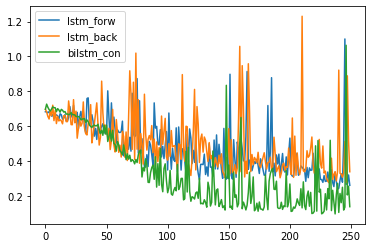

In [ ]:

from random import random
from numpy import array
from numpy import cumsum
from matplotlib import pyplot
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
 
# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y
 
def get_lstm_model(n_timesteps, backwards):
	model = Sequential()
	model.add(LSTM(20, input_shape=(n_timesteps, 1), return_sequences=True, go_backwards=backwards))
	model.add(TimeDistributed(Dense(1, activation='sigmoid')))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
def get_bi_lstm_model(n_timesteps, mode):
	model = Sequential()
	model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1), merge_mode=mode))
	model.add(TimeDistributed(Dense(1, activation='sigmoid')))
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
def train_model(model, n_timesteps):
	loss = list()
	for _ in range(250):
		# generate new random sequence
		X,y = get_sequence(n_timesteps)
		# fit model for one epoch on this sequence
		hist = model.fit(X, y, epochs=1, batch_size=1, verbose=0)
		loss.append(hist.history['loss'][0])
	return loss
 
 
n_timesteps = 10
results = DataFrame()
# lstm forwards
model = get_lstm_model(n_timesteps, False)
results['lstm_forw'] = train_model(model, n_timesteps)
# lstm backwards
model = get_lstm_model(n_timesteps, True)
results['lstm_back'] = train_model(model, n_timesteps)
# bidirectional concat
model = get_bi_lstm_model(n_timesteps, 'concat')
results['bilstm_con'] = train_model(model, n_timesteps)
# line plot of results
results.plot()
pyplot.show()

In [ ]:
## The below code is for test a hypothesis only. 

In [ ]:
from pandas import read_csv
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

# Get input data and separate features from labels
df = read_csv("iris.data")
Y = df.iloc[:,4]
X = df.iloc[:, : 4]

# Split data set in train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, random_state=seed(1234))

# Input information
col_num = X.shape[1]
input_dim = Input(shape=(col_num,))

# Encoding information
encoding_dim = 2
encoded = Dense(encoding_dim, activation='relu')(input_dim)
# Decoding information
decoded = Dense(col_num, activation='sigmoid')(encoded)
# Autoencoder information (encoder + decoder)
autoencoder = Model(input=input_dim, output=decoded)

# Train the autoencoder
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.fit(X_train, X_train, nb_epoch=50, batch_size=100, shuffle=True, validation_data=(X_test, X_test))

# Encoder information for feature extraction
encoder = Model(input=input_dim, output=encoded)
encoded_input = Input(shape=(encoding_dim,))
encoded_output = encoder.predict(X_test)

# Show the encoded values
print(encoded_output[:5])